In [4]:
import pandas as pd
import geopandas as gpd
from shapely import Point
import numpy as np
import os
print(os.getcwd())

/home/jovyan/data-analyses/transit_priority


In [5]:
sfmta_signals = pd.read_csv('Traffic_Signals_20240205.csv')
sfmta_signals.head()


FileNotFoundError: [Errno 2] No such file or directory: 'Traffic_Signals_20240205.csv'

In [ ]:
def parse_point_geometry(geometry_str):
    coordinates = geometry_str.replace("POINT", "").strip().lstrip("(").rstrip(")").split()
    x, y = map(float, coordinates)
    point = Point(x, y)
    return point

sfmta_signals['geometry'] = sfmta_signals['shape'].apply(parse_point_geometry)

In [ ]:
gdf = gpd.GeoDataFrame(sfmta_signals, geometry='geometry')

In [ ]:
gdf.plot()

In [21]:
def merge_columns(row):
    if row['CALTRANS'] == 'X':
        return 'Caltrans'
    else:
        return 'SFMTA'

gdf['owner'] = gdf.apply(merge_columns, axis=1)

## Get only TSP signals

In [22]:
remove_list = ['FIRE PREEMPT', 'TSP-Planned,FIRE PREEMPT', 'TSP-Planned', 'nan']
gdf['PREEMPT_PR'] = gdf['PREEMPT_PR'].replace('nan', np.nan)
# Filter the GeoDataFrame to remove rows with values in the remove_list
filtered_gdf = gdf[~(gdf['PREEMPT_PR'].isin(remove_list) | gdf['PREEMPT_PR'].isna())]

filtered_gdf["PREEMPT_PR"].unique()

array(['TSP,FIRE PREEMPT', 'CABLE CAR PREEMPTION', 'TSP',
       'TSP,HEAVY RAIL PREEMPT', 'CABLE CAR PREEMPTION,FIRE PREEMPT',
       'TRANSIT PREEMPT', 'ACTUATED TRANSIT PHASE',
       'FIRE PREEMPT,TRANSIT PREEMPT', 'TSP,FIRE PREEMPT,TRANSIT PREEMPT',
       'TSP,CABLE CAR PREEMPT',
       'TSP,ACTUATED TRANSIT PHASE,TRANSIT PREEMPT', 'BRIDGE PREEMPT',
       'HEAVY RAIL,FIRE,BRIDGE, TRANSIT PREEMPT', 'TSP,TRANSIT PREEMPT',
       'TSP,ACTUATED TRANSIT PHASE',
       'TSP,ACTUATED TRANSIT PHASE,FIRE PREEMPT', 'TSP,BRIDGE PREEMPT',
       'HEAVY RAIL,BRIDGE PREEMPT', 'HEAVY RAIL PREEMPT',
       'HEAVY RAIL,BRIDGE PREEMPT, TRANSIT PREEMPT'], dtype=object)

In [23]:
filtered_gdf.columns
gdf_new = filtered_gdf[['STREET1','STREET2','STREET3','STREET4','PREEMPT_PR','LAST_UPGRA','data_as_of','geometry','owner']].copy()
gdf_new.rename(columns={'PREEMPT_PR':'TSP_Type','LAST_UPGRA':'start_date'},inplace=True)

<AxesSubplot:>

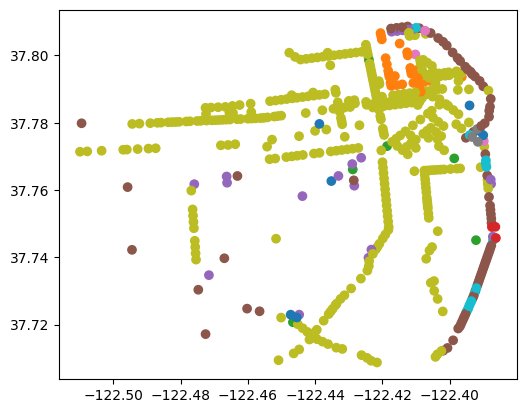

In [24]:
gdf_new.plot(gdf_new['TSP_Type'])
# Manually check to see if this matches 
# https://www.sfmta.com/sites/default/files/reports-and-documents/2023/02/bus_transit_signal_priority.pdf

In [25]:
for i in gdf_new["TSP_Type"].unique():
    print(str(i))

TSP,FIRE PREEMPT
CABLE CAR PREEMPTION
TSP
TSP,HEAVY RAIL PREEMPT
CABLE CAR PREEMPTION,FIRE PREEMPT
TRANSIT PREEMPT
ACTUATED TRANSIT PHASE
FIRE PREEMPT,TRANSIT PREEMPT
TSP,FIRE PREEMPT,TRANSIT PREEMPT
TSP,CABLE CAR PREEMPT
TSP,ACTUATED TRANSIT PHASE,TRANSIT PREEMPT
BRIDGE PREEMPT
HEAVY RAIL,FIRE,BRIDGE, TRANSIT PREEMPT
TSP,TRANSIT PREEMPT
TSP,ACTUATED TRANSIT PHASE
TSP,ACTUATED TRANSIT PHASE,FIRE PREEMPT
TSP,BRIDGE PREEMPT
HEAVY RAIL,BRIDGE PREEMPT
HEAVY RAIL PREEMPT
HEAVY RAIL,BRIDGE PREEMPT, TRANSIT PREEMPT


In [26]:
gdf_new.head()

,STREET1,STREET2,STREET3,STREET4,TSP_Type,start_date,data_as_of,geometry,owner
5,04TH ST,16TH ST,NaN,NaN,"TSP,FIRE PREEMPT",2010,04/26/2023 03:25:40 PM,POINT (-122.39080 37.76680),SFMTA
11,JACKSON,POWELL,NaN,NaN,CABLE CAR PREEMPTION,0,04/26/2023 03:24:48 PM,POINT (-122.40990 37.79562),SFMTA
12,03RD ST,LE CONTE,NaN,NaN,TSP,2005,04/26/2023 03:25:40 PM,POINT (-122.39748 37.71883),SFMTA
13,KING,MIDBLOCK AT,04TH ST,05TH ST,TSP,1997,04/26/2023 03:25:40 PM,POINT (-122.39519 37.77553),SFMTA
15,03RD ST,INGERSON,NaN,NaN,TSP,2004,04/26/2023 03:24:48 PM,POINT (-122.39627 37.72098),SFMTA


In [27]:
gdf_new.to_file("SFTMA_signals.json", driver="GeoJSON")